In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import matplotlib as mpl

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *
from proc_revisions.ss_sj_utils import *


In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
read_lens = od+expand(config['lr']['read_len_meta'], species='human')[0]
introp_bed = od+expand(config['intropolis']['bed'], species='human')[0]

gene_subset = 'polya'
ref_sources = ['v29', 'v40']
min_tpm = 1

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]
m_read_lens = od+expand(config['lr']['read_len_meta'], species='mouse')[0]
m_ref_sources = ['vM21', 'vM25']

## How well supported are splice junctions? 

In [16]:
ca = cerberus.read(cerberus_h5)

In [19]:
sj_df, sj_ic_df = get_sj_from_ic(ca.ic, ref_sources)

In [20]:
# read intropolis 
i_df = pr.read_bed(introp_bed).df
source = 'intropolis'
i_df['source'] = source
i_df = i_df.loc[i_df.Start.notnull()]
i_df[source] = True

keep_cols = ['Chromosome', 'Start', 'End', 'Strand', 'intropolis']
i_df = i_df[keep_cols].drop_duplicates()

In [21]:
# merge in
df = sj_df.merge(i_df[keep_cols],
                how='left',
                on=['Chromosome', 'Start', 'End', 'Strand'])
df[source] = df[source].fillna(False)
df[['Start', 'intropolis']].groupby('intropolis').count()

,Start
intropolis,
False,29712
True,423291


In [22]:
df[['novelty', 'intropolis', 'Start']].groupby(['novelty', 'intropolis']).count()

Start
novelty intropolis        
Known   False        24897
        True        383883
Novel   False         4815
        True         39408

## Determine % of splice junctions supported per IC


In [23]:
keep_cols = ['Chromosome', 'Strand', 'Start', 'End', 'intropolis']
temp = sj_ic_df.merge(df[keep_cols], 
                    how='left',
                    on=['Chromosome', 'Start', 'End', 'Strand'])

In [24]:
# how many sjs / intron chain
temp2 = temp[['Name', 'Start']].groupby(['Name']).count().reset_index().rename({'Start':'n_sjs'}, axis=1)

In [25]:
# how many intropolis supported sjs / intron chain
temp3 = temp.loc[temp.intropolis == True]
temp3 = temp3[['Name', 'intropolis']].groupby(['Name']).count().reset_index().rename({'intropolis':'n_sjs_supported'}, axis=1)

In [26]:
ic = ca.ic.copy(deep=True)
ic = ic.loc[ic.Coordinates != '-'] # remove monoexonic
ic = ic.merge(temp2, how='left', on='Name')
ic = ic.merge(temp3, how='left', on='Name')

In [30]:
# make sure that ICs w/o support are added too
ic.n_sjs_supported.fillna(False, inplace=True)
ic['perc_supported'] = (ic['n_sjs_supported']/ic['n_sjs'])*100

In [14]:
# what does % sj support by intropolis look like for 
# detected ics by novelty category
ab_df = pd.read_csv(filt_ab, sep='\t')
ab_df, ic_ids = get_tpm_table(ab_df,
               how='ic',
               gene_subset=gene_subset,
               min_tpm=min_tpm)

Calculating ic TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2087: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2086: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # ics detected: 145392
# ics >= 1 tpm: 131409
Applying gene type and novelty subset
Number of ics reported: 128159


In [15]:
# limit to detected ics
print(ic_ids[:5])
ic.head()
ic = ic.loc[ic.Name.isin(ic_ids)]
len(ic.index)

['ENSG00000000003_1', 'ENSG00000000003_10', 'ENSG00000000003_11', 'ENSG00000000003_12', 'ENSG00000000003_4']


128159

In [16]:
# percent of ics w/ 100% support per novelty category
ic['fully_supported'] = False
ic.loc[ic.perc_supported==100, 'fully_supported'] = True
ic.tail()

,Chromosome,Strand,Coordinates,Name,source,novelty,gene_id,ic,n_sjs,n_sjs_supported,perc_supported,fully_supported
301113,chrY,+,14522941-14622008-14622591-14723116-14723269-1...,ENSG00000165246_12,lapa,NIC,ENSG00000165246,12,5.0,5.0,100.0,True
301116,chrY,+,2935446-2961073-2961646-2975094-2975244-297551...,ENSG00000067646_8,lapa,NIC,ENSG00000067646,8,6.0,6.0,100.0,True
301117,chrY,+,5000605-5002687,ENSG00000099715_8,lapa,ISM,ENSG00000099715,8,1.0,1.0,100.0,True
301118,chrY,-,13479513-13479317-13479253-13470229-13470120-1...,ENSG00000183878_23,lapa,NIC,ENSG00000183878,23,28.0,28.0,100.0,True
301120,chrY,-,19744670-19744553-19744384-19743239-19743161-1...,ENSG00000012817_11,lapa,NNC,ENSG00000012817,11,26.0,26.0,100.0,True


In [18]:
ic.loc[ic.perc_supported.notnull()].head()

,Chromosome,Strand,Coordinates,Name,source,novelty,gene_id,ic,n_sjs,n_sjs_supported,perc_supported,fully_supported
1084,chr1,+,100038316-100049908-100050004-100058665-100058...,ENSG00000156875_1,"v40,v29,lapa,gtex",Known,ENSG00000156875,1,21.0,21.0,100.0,True
1086,chr1,+,1001263-1008193-1008279-1013983,ENSG00000187608_3,"v40,v29,lapa,gtex",Known,ENSG00000187608,3,2.0,2.0,100.0,True
1087,chr1,+,1001281-1008193-1008279-1013983,ENSG00000187608_2,"v40,v29,lapa",Known,ENSG00000187608,2,2.0,2.0,100.0,True
1088,chr1,+,100133315-100136881-100136928-100137018-100137...,ENSG00000122435_1,"v40,v29,lapa",Known,ENSG00000122435,1,10.0,10.0,100.0,True
1089,chr1,+,100133315-100136881-100136928-100137018-100137...,ENSG00000122435_4,"v40,v29,lapa",Known,ENSG00000122435,4,7.0,7.0,100.0,True


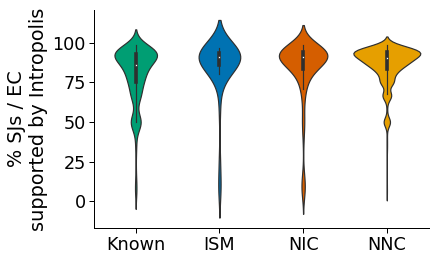

In [28]:
# for the ics that are not 100% supported, what does the support like
ic_temp = ic.loc[ic.perc_supported!=100]
c_dict, order = get_ic_nov_colors(cats=ic_temp.novelty.unique().tolist())
sns.set_context('paper', font_scale=2)
            
ax = sns.violinplot(ic_temp, x='novelty', y='perc_supported',
            palette=c_dict, saturation=1, order=order)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ylabel = f'% SJs / EC\nsupported by Intropolis'
_ = ax.set(ylabel=ylabel, xlabel='')
# for i, c in enumerate(order):
#     temp2 = temp.loc[temp.novelty==c]
#     n = temp2.n_ic.values[0]
#     add_n(ax, n, i)

In [ ]:
temp = ic[['fully_supported', 'novelty', 'Name']].groupby(['fully_supported', 'novelty']).count().reset_index().rename({'Name': 'n_ic'}, axis=1)
temp2 = ic[['Name', 'novelty']].groupby('novelty').count().reset_index().rename({'Name':'n_total_ic'}, axis=1)

In [78]:
# only fully supported
temp = temp.loc[temp.fully_supported==True]
temp = temp.merge(temp2, how='left', on='novelty')
temp['perc_fully_supported'] = (temp.n_ic/temp.n_total_ic)*100
temp

,fully_supported,novelty,n_ic,n_total_ic,perc_fully_supported
0,True,ISM,9950,10030,99.202393
1,True,Known,74749,82555,90.544485
2,True,NIC,20903,21324,98.025699
3,True,NNC,12596,14250,88.392982


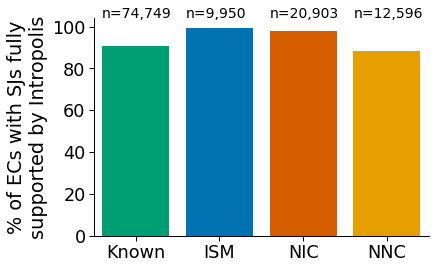

In [121]:
c_dict, order = get_ic_nov_colors(cats=temp.novelty.unique().tolist())
sns.set_context('paper', font_scale=2)

def add_n(ax, n, i):
    ylim = ax.get_ylim()[1]
    n_cats = len(ax.patches)
    for j, p in enumerate(ax.patches):
        if i != j:
            continue
        label = f'n={n:,}'
        perc = p.get_height()
        x = p.get_x() + p.get_width() / 2 - (0.1)*n_cats
        # y = p.get_y() + p.get_height() + ylim*0.04
        y = ylim
        ax.annotate(label, (x, y), size = 14)
            
ax = sns.barplot(temp, x='novelty', y='perc_fully_supported',
            palette=c_dict, saturation=1, order=order)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ylabel = f'% of ECs with SJs fully\nsupported by Intropolis'
_ = ax.set(ylabel=ylabel, xlabel='')
for i, c in enumerate(order):
    temp2 = temp.loc[temp.novelty==c]
    n = temp2.n_ic.values[0]
    add_n(ax, n, i)

## What % of novel splice junctions from detected ics that we call are supported by intropolis?

In [123]:
det_sjs = sj_ic_df.loc[sj_ic_df.Name.isin(ic_ids)]

# whether these sjs were detected in intropolis
print(len(det_sjs))
det_sjs = det_sjs.merge(df[['gene_id', 'Chromosome', 'Start', 'End', 'Strand', 'intropolis']], 
                               on=['gene_id', 'Chromosome', 'Start', 'End', 'Strand'],
                               how='left')
print(len(det_sjs))

957965
957965


In [136]:
temp

,intropolis,novelty,count
0,False,Known,5589
1,False,Novel,1851
2,True,Known,930310
3,True,Novel,20215


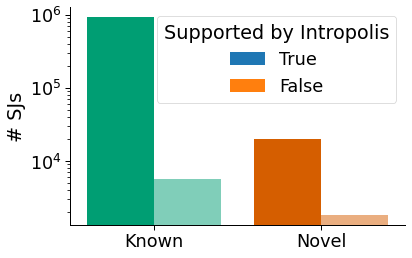

In [138]:
temp = det_sjs[['intropolis', 'novelty', 'Start']].groupby(['intropolis', 'novelty']).count().reset_index().rename({'Start':'count'}, axis=1)
sns.set_context('paper', font_scale=2)

def get_nov_colors(cats=None):
    c_dict = {'Known': '#009E73',
              'Novel': '#D55E00'}
    order = ['Known', 'Novel']

    c_dict, order = rm_color_cats(c_dict, order, cats)
    return c_dict, order

c_dict, order = get_nov_colors(cats=temp.novelty.unique().tolist())
temp['novelty'] = temp['novelty'].astype('category')
temp['novelty'] = temp['novelty'].cat.reorder_categories(order, ordered=True)
cats = [True, False]
temp['intropolis'] = temp['intropolis'].astype('category')
temp['intropolis'] = temp['intropolis'].cat.reorder_categories(cats, ordered=True)

ax = sns.barplot(data=temp, 
            x='novelty',
            hue='intropolis',
            y='count',
            hue_order=[True, False],
            saturation=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yscale('log')
ax.legend().set_title('Supported by Intropolis')
ax.set(ylabel='# SJs', xlabel='')

for bar_group, cat in zip(ax.containers, cats):
    for bar, cat2 in zip(bar_group, order):
        c = c_dict[cat2]
        c_dict_2, order_2 = get_shade_colors(c, cats)
        bar.set_facecolor(c_dict_2[cat])

## How well supported are splice sites? 

In [49]:
ca = cerberus.read(cerberus_h5)

In [50]:
ref_sources

['v29', 'v40']

In [51]:
ss_df, ss_ic_df = get_ss_from_ic(ca.ic, ref_sources)

In [52]:
# read intropolis 
i_df = pr.read_bed(introp_bed).df
source = 'intropolis'
i_df['source'] = source
i_df = i_df.loc[i_df.Start.notnull()]
i_df[source] = True

keep_cols = ['Chromosome', 'Start', 'End', 'Strand', 'intropolis']
i_df = i_df[keep_cols].drop_duplicates()

In [53]:
i_df['ss_5'] = np.nan
i_df['ss_3'] = np.nan
i_df.loc[i_df.Strand == '+', 'ss_5'] = i_df.loc[i_df.Strand == '+', 'Start']
i_df.loc[i_df.Strand == '+', 'ss_3'] = i_df.loc[i_df.Strand == '+', 'End']

i_df.loc[i_df.Strand == '-', 'ss_5'] = i_df.loc[i_df.Strand == '-', 'End']
i_df.loc[i_df.Strand == '-', 'ss_3'] = i_df.loc[i_df.Strand == '-', 'Start']
i_df.loc[i_df.Strand == '+']
i_df = i_df[['Chromosome', 'Strand', 'intropolis', 'ss_5', 'ss_3']]
i_df.head()

,Chromosome,Strand,intropolis,ss_5,ss_3
0,chr1,+,True,10580.0,12009.0
1,chr1,+,True,10591.0,12009.0
2,chr1,+,True,10774.0,10846.0
3,chr1,+,True,10803.0,10953.0
4,chr1,+,True,10865.0,10941.0


In [54]:
i_df = i_df.melt(id_vars=['Chromosome', 'Strand', 'intropolis'],value_vars=['ss_5', 'ss_3'], var_name='ss_type', value_name='coord')

In [55]:
i_df.rename({'coord': 'Start'}, axis=1, inplace=True)
i_df.head()

,Chromosome,Strand,intropolis,ss_type,Start
0,chr1,+,True,ss_5,10580.0
1,chr1,+,True,ss_5,10591.0
2,chr1,+,True,ss_5,10774.0
3,chr1,+,True,ss_5,10803.0
4,chr1,+,True,ss_5,10865.0


In [56]:
# merge in
merge_cols = ['Chromosome', 'Strand', 'ss_type', 'Start', 'intropolis']

df = ss_df.merge(i_df[merge_cols],
                how='left',
                on=['Chromosome', 'Start', 'Strand', 'ss_type'])
df[source] = df[source].fillna(False)
df[['Start', 'intropolis']].groupby('intropolis').count()

,Start
intropolis,
False,30192
True,7635854


In [57]:
df[['novelty', 'intropolis', 'Start']].groupby(['novelty', 'intropolis']).count()

Start
novelty intropolis         
Known   False         29159
        True        7372058
Novel   False          1033
        True         263796

## Determine % of splice sites supported per IC


In [58]:
keep_cols = ['Chromosome', 'Strand', 'Start', 'ss_type', 'intropolis']
temp = ss_ic_df.merge(df[keep_cols], 
                    how='left',
                    on=['Chromosome', 'Start', 'ss_type', 'Strand'])

In [59]:
# how many sss / intron chain
temp2 = temp[['Name', 'Start']].groupby(['Name']).count().reset_index().rename({'Start':'n_sss'}, axis=1)

In [60]:
# how many intropolis supported sss / intron chain
temp3 = temp.loc[temp.intropolis == True]
temp3 = temp3[['Name', 'intropolis']].groupby(['Name']).count().reset_index().rename({'intropolis':'n_sss_supported'}, axis=1)

In [61]:
ic = ca.ic.copy(deep=True)
ic = ic.loc[ic.Coordinates != '-'] # remove monoexonic
ic = ic.merge(temp2, how='left', on='Name')
ic = ic.merge(temp3, how='left', on='Name')

In [62]:
# make sure that ICs w/o support are added too
ic.n_sss_supported.fillna(False, inplace=True)
ic['perc_supported'] = (ic['n_sss_supported']/ic['n_sss'])*100

In [63]:
# what does % ss support by intropolis look like for 
# detected ics by novelty category
ab_df = pd.read_csv(filt_ab, sep='\t')
ab_df, ic_ids = get_tpm_table(ab_df,
               how='ic',
               gene_subset=gene_subset,
               min_tpm=min_tpm)

Calculating ic TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2087: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2086: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # ics detected: 145392
# ics >= 1 tpm: 131409
Applying gene type and novelty subset
Number of ics reported: 128159


In [64]:
# limit to detected ics
print(ic_ids[:5])
ic.head()
ic = ic.loc[ic.Name.isin(ic_ids)]
len(ic.index)

['ENSG00000000003_1', 'ENSG00000000003_10', 'ENSG00000000003_11', 'ENSG00000000003_12', 'ENSG00000000003_4']


128159

In [65]:
# percent of ics w/ 100% support per novelty category
ic['fully_supported'] = False
ic.loc[ic.perc_supported==100, 'fully_supported'] = True
ic.tail()

,Chromosome,Strand,Coordinates,Name,source,novelty,gene_id,ic,n_sss,n_sss_supported,perc_supported,fully_supported
301113,chrY,+,14522941-14622008-14622591-14723116-14723269-1...,ENSG00000165246_12,lapa,NIC,ENSG00000165246,12,218.0,218.0,100.0,True
301116,chrY,+,2935446-2961073-2961646-2975094-2975244-297551...,ENSG00000067646_8,lapa,NIC,ENSG00000067646,8,106.0,106.0,100.0,True
301117,chrY,+,5000605-5002687,ENSG00000099715_8,lapa,ISM,ENSG00000099715,8,10.0,10.0,100.0,True
301118,chrY,-,13479513-13479317-13479253-13470229-13470120-1...,ENSG00000183878_23,lapa,NIC,ENSG00000183878,23,821.0,821.0,100.0,True
301120,chrY,-,19744670-19744553-19744384-19743239-19743161-1...,ENSG00000012817_11,lapa,NNC,ENSG00000012817,11,435.0,435.0,100.0,True


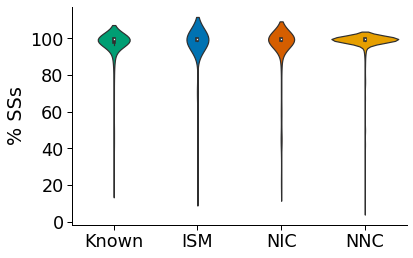

In [66]:
# for the ics that are not 100% supported, what does the support like
ic_temp = ic.loc[ic.perc_supported!=100]
c_dict, order = get_ic_nov_colors(cats=ic_temp.novelty.unique().tolist())
sns.set_context('paper', font_scale=2)

def add_n(ax, n, i):
    ylim = ax.get_ylim()[1]
    n_cats = len(ax.patches)
    for j, p in enumerate(ax.patches):
        if i != j:
            continue
        label = f'n={n:,}'
        perc = p.get_height()
        x = p.get_x() + p.get_width() / 2 - (0.1)*n_cats
        # y = p.get_y() + p.get_height() + ylim*0.04
        y = ylim
        ax.annotate(label, (x, y), size = 14)
            
ax = sns.violinplot(ic_temp, x='novelty', y='perc_supported',
            palette=c_dict, saturation=1, order=order)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ylabel = f'% SSs'
_ = ax.set(ylabel=ylabel, xlabel='')
# for i, c in enumerate(order):
#     temp2 = temp.loc[temp.novelty==c]
#     n = temp2.n_ic.values[0]
#     add_n(ax, n, i)

In [67]:
temp = ic[['fully_supported', 'novelty', 'Name']].groupby(['fully_supported', 'novelty']).count().reset_index().rename({'Name': 'n_ic'}, axis=1)
temp2 = ic[['Name', 'novelty']].groupby('novelty').count().reset_index().rename({'Name':'n_total_ic'}, axis=1)

In [68]:
# only fully supported
temp = temp.loc[temp.fully_supported==True]
temp = temp.merge(temp2, how='left', on='novelty')
temp['perc_fully_supported'] = (temp.n_ic/temp.n_total_ic)*100
temp

,fully_supported,novelty,n_ic,n_total_ic,perc_fully_supported
0,True,ISM,9954,10030,99.242273
1,True,Known,74885,82555,90.709224
2,True,NIC,20961,21324,98.297693
3,True,NNC,13254,14250,93.010526


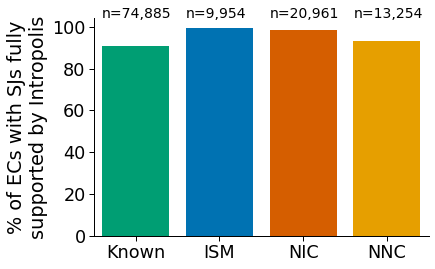

In [69]:
c_dict, order = get_ic_nov_colors(cats=temp.novelty.unique().tolist())
sns.set_context('paper', font_scale=2)

def add_n(ax, n, i):
    ylim = ax.get_ylim()[1]
    n_cats = len(ax.patches)
    for j, p in enumerate(ax.patches):
        if i != j:
            continue
        label = f'n={n:,}'
        perc = p.get_height()
        x = p.get_x() + p.get_width() / 2 - (0.1)*n_cats
        # y = p.get_y() + p.get_height() + ylim*0.04
        y = ylim
        ax.annotate(label, (x, y), size = 14)
            
ax = sns.barplot(temp, x='novelty', y='perc_fully_supported',
            palette=c_dict, saturation=1, order=order)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ylabel = f'% of ECs with SJs fully\nsupported by Intropolis'
_ = ax.set(ylabel=ylabel, xlabel='')
for i, c in enumerate(order):
    temp2 = temp.loc[temp.novelty==c]
    n = temp2.n_ic.values[0]
    add_n(ax, n, i)

## What % of novel splice sites from detected ics that we call are supported by intropolis?

In [70]:
det_sss = ss_ic_df.loc[ss_ic_df.Name.isin(ic_ids)]

# whether these sjs were detected in intropolis
print(len(det_sss))
det_sss = det_sss.merge(df[['gene_id', 'Chromosome', 'Start', 'ss_type', 'Strand', 'intropolis']], 
                               on=['gene_id', 'Chromosome', 'Start', 'ss_type', 'Strand'],
                               how='left')
print(len(det_sss))

1915930
32361795


In [71]:
temp

,fully_supported,novelty,n_ic,n_total_ic,perc_fully_supported
0,True,ISM,9954,10030,99.242273
1,True,Known,74885,82555,90.709224
2,True,NIC,20961,21324,98.297693
3,True,NNC,13254,14250,93.010526


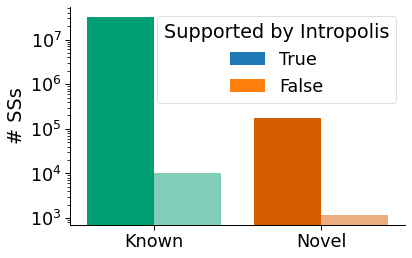

In [72]:
temp = det_sss[['intropolis', 'novelty', 'Start']].groupby(['intropolis', 'novelty']).count().reset_index().rename({'Start':'count'}, axis=1)
sns.set_context('paper', font_scale=2)

def get_nov_colors(cats=None):
    c_dict = {'Known': '#009E73',
              'Novel': '#D55E00'}
    order = ['Known', 'Novel']

    c_dict, order = rm_color_cats(c_dict, order, cats)
    return c_dict, order

c_dict, order = get_nov_colors(cats=temp.novelty.unique().tolist())
temp['novelty'] = temp['novelty'].astype('category')
temp['novelty'] = temp['novelty'].cat.reorder_categories(order, ordered=True)
cats = [True, False]
temp['intropolis'] = temp['intropolis'].astype('category')
temp['intropolis'] = temp['intropolis'].cat.reorder_categories(cats, ordered=True)

ax = sns.barplot(data=temp, 
            x='novelty',
            hue='intropolis',
            y='count',
            hue_order=[True, False],
            saturation=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yscale('log')
ax.legend().set_title('Supported by Intropolis')
ax.set(ylabel='# SSs', xlabel='')

for bar_group, cat in zip(ax.containers, cats):
    for bar, cat2 in zip(bar_group, order):
        c = c_dict[cat2]
        c_dict_2, order_2 = get_shade_colors(c, cats)
        bar.set_facecolor(c_dict_2[cat])

## What % of novel SJs are supported by intropolis?

In [55]:
sj_df, sj_ic_df = get_sj_from_ic(ca.ic, ref_sources)

In [56]:
ca.ic.head()

,Chromosome,Strand,Coordinates,Name,source,novelty,gene_id,ic
0,chr1,+,-,ENSG00000004487_18,"v40,v29,lapa",Known,ENSG00000004487,18
1,chr1,+,-,ENSG00000033122_5,"v40,v29,lapa",Known,ENSG00000033122,5
2,chr1,+,-,ENSG00000049246_6,"v40,v29,lapa",Known,ENSG00000049246,6
3,chr1,+,-,ENSG00000077157_8,"v40,v29,lapa",Known,ENSG00000077157,8
4,chr1,+,-,ENSG00000099260_3,"v40,v29,lapa",Known,ENSG00000099260,3


In [57]:
# read intropolis 
i_df = pr.read_bed(introp_bed).df
source = 'intropolis'
i_df['source'] = source
i_df = i_df.loc[i_df.Start.notnull()]
i_df[source] = True

keep_cols = ['Chromosome', 'Start', 'End', 'Strand', 'intropolis']
i_df = i_df[keep_cols].drop_duplicates()

In [58]:
# merge in

df = sj_df.merge(i_df[keep_cols],
                how='left',
                on=['Chromosome', 'Start', 'End', 'Strand'])
df[source] = df[source].fillna(False)

In [59]:
df.head()
df['sj'] = df.Chromosome+df.Strand+df.Start.astype(str)+df.End.astype(str)
df = df[['novelty','intropolis','sj']].groupby(['novelty', 'intropolis']).count()
df = df.reset_index()

In [60]:
df.head()
temp = df[['novelty', 'sj']].groupby('novelty').sum().reset_index()
temp.rename({'sj': 'total'}, axis=1, inplace=True)
df = df.merge(temp, on='novelty', how='left')
df['perc'] = (df['sj']/df['total'])*100
df

,novelty,intropolis,sj,total,perc
0,Known,False,24783,408666,6.064366
1,Known,True,383883,408666,93.935634
2,Novel,False,4815,44223,10.887999
3,Novel,True,39408,44223,89.112001


<AxesSubplot:xlabel='novelty', ylabel='sj'>

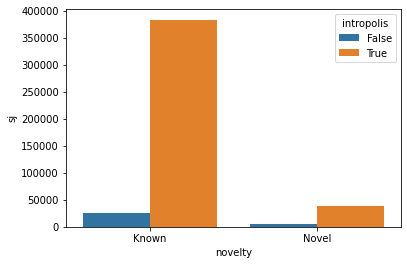

In [61]:
df
sns.barplot(df, x='novelty', y='sj', hue='intropolis')

<AxesSubplot:xlabel='novelty', ylabel='perc'>

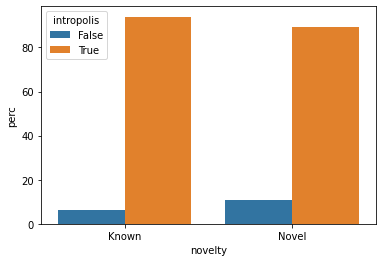

In [62]:
df
sns.barplot(df, x='novelty', y='perc', hue='intropolis')